# **Multi-Model Surface Water Mass Transformation Analysis**

## Header

In [2]:
from esnb import CaseGroup2, NotebookDiagnostic, RequestedVariable
from esnb.sites.gfdl import call_dmget

mode = "prod"
verbose = True

diag_name = "Multi-Model Surface Water Mass Transformation Analysis"
diag_desc = "This is a multi-model notebook for SWMT analysis. " \
            "This allows for users to look at surface water mass transformations in average time, monthly, and seasonally" \
            " to see where and what fluxes are driving water mass formation or dense water formation in the case of density. " \
            " This notebook supports many experiments to allow direct comparison in location and magnitude of swmt."
 
# these variables are what are being used to calculate surface water mass transformation in the coupled models
# if using ocean only, salinity restoring is required. 
variables = [
    RequestedVariable("tos", "ocean_monthly"),
    RequestedVariable("sos", "ocean_monthly"),
    RequestedVariable("hfds", "ocean_monthly"),
    RequestedVariable("wfo", "ocean_monthly"),
    RequestedVariable("sfdsi", "ocean_monthly"),
    RequestedVariable("friver", "ocean_monthly"), # salt start
    RequestedVariable("ficeberg", "ocean_monthly"),
    #RequestedVariable("fsitherm", "ocean_monthly"),
    RequestedVariable("evs", "ocean_monthly"),
    #RequestedVariable("vprec", "ocean_monthly"),
    RequestedVariable("prsn", "ocean_monthly"),
    RequestedVariable("prlq", "ocean_monthly"),
    RequestedVariable("hflso", "ocean_monthly"), # heat start 
    RequestedVariable("hfsso", "ocean_monthly"), 
    RequestedVariable("rlntds", "ocean_monthly"), 
    RequestedVariable("rsntds", "ocean_monthly"), 
    RequestedVariable("siconc", "ice"),
]

user_options = {"N/A": ["N/A"]}

diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables, **user_options)

# supports many experiments, 1 to n
groups = [
    #CaseGroup("odiv-1", date_range=("0200-01-01", "0400-12-31"), verbose=verbose),
    #CaseGroup2("895", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("2198", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("2916", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("3015", date_range=("0200-01-01", "0230-12-31")),
    #CaseGroup2("odiv-3", date_range=("0001-01-01", "0003-12-31")),
    CaseGroup2("895", date_range=("0101-01-01", "0103-12-31")),
    CaseGroup2("2198", date_range=("0101-01-01", "0103-12-31")),
    CaseGroup2("2916", date_range=("0101-01-01", "0103-12-31")),
    #CaseGroup2("3015", date_range=("0101-01-01", "0120-12-31")),
]


Matplotlib is building the font cache; this may take a moment.


FileNotFoundError: https://dora.gfdl.noaa.gov/api/intake/895.json

In [2]:
diag.resolve(groups)

def diag_get():
    """
    helper function to dmget to get dsets of above vars/files
    """
    call_dmget(diag.files)
    diag.open()
diag_get()

dmget: Dmgetting 114 of 240 files requested (41021.9 MB)


## Imports

In [3]:
import xwmt # This is xwmt-new
import numpy as np
import os
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import momgrid as mg
from momgrid.geoslice import geoslice
import os as os
import cartopy.crs as ccrs
import gsw  # TEOS-10
import xbudget
import xgcm
from cmip_basins.basins import generate_basin_codes
import copy
import cartopy.feature as cfeature
import cmocean
import pandas as pd
from matplotlib.lines import Line2D
from collections.abc import Sequence

os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/jpk/grid_weights" # get rid of any momgrid
variables_names = [variable.varname for variable in variables]

## Functions

In [5]:
def realm_list():
    """
    returns dsets[i][j], s.t. i is the case experiment with all variables, and j is the realm
    """
    diag_get()
    out = []
    ice_var = next((v for v in variables if v.varname == "siconc"), None)

    for g in diag.groups:
        d = g.datasets
        realms = []
        nonice = [d[v] for v in variables if v is not ice_var]
        if nonice:
            realms.append(xr.merge(nonice).sortby("time").dropna(dim="time", how="all"))

        if ice_var:
            realms.append(d[ice_var])

        out.append(realms)

    return out


def groupCoordinateChange(raw_dsets, groups, basin_integer=None):
    """
    Given some case groups list as groups, performs appropriate
    remappings of variable names to be compatible to xwmt python package
    maps:
        xh->x
        yh->y
        geolat->lat
        geolon->lon
    inputs
    - dsets[n][i] which is indexed by n as the CaseGroup n, and i as the realm of data (i.e. ocean_month, atmos_cmip, etc.)
    - groups as list of CaseGroup objects corresponding to the
    - basin_integer
    outputs
    - dsets[n][i] as the list of lists xarray dataset experiments
    - basincodes_arr[n][i] as the list of lists basincodes (i.e. some integer for each basin)
    """
    dsets_copy = copy.deepcopy(raw_dsets)
    basincodes_arr = [[None for _ in row] for row in dsets_copy]
    coords = {
        "X": {
            "center": "x",
        },
        "Y": {
            "center": "y",
        },
    }
    metrics = {("X", "Y"): "areacello"}
    for n, group in enumerate(groups):
        for i, ds in enumerate(dsets_copy[n]):
            dsets_copy[n][i] = mg.Gridset(ds).data
            # this must be made more agnostic
            if "y" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"yh": "y"})
            if "x" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"xh": "x"})
            if "lat" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"geolat": "lat"})
            if "lon" not in list(dsets_copy[n][i].coords):
                dsets_copy[n][i] = dsets_copy[n][i].rename({"geolon": "lon"})
            if not "sfdsi" in ds:
                print("sfdsi is missing: Add all-zero field for sfdsi based on hfds")
                dsets_copy[n][i]["sfdsi"] = xr.zeros_like(
                    dsets_copy[n][i]["hfds"]
                ).rename("sfdsi")
                dsets_copy[n][i]["sfdsi"].attrs = {}
            if basin_integer is not None:
                basincodes_arr[n][i] = generate_basin_codes(
                    dsets_copy[n][i], lon="lon", lat="lat", mask="wet"
                )
                if basin_integer > 10:
                    # if greater than 10, this mask is a custom mask, which must be created, not from cmip basins
                    basincodes_arr[n][i] = custom_basins(
                        basin_integer, basincodes_arr[n][i]
                    )
                    dsets_copy[n][i] = (
                        dsets_copy[n][i]
                        .where((basincodes_arr[n][i] == basin_integer))
                        .copy(deep=True)
                    )
                else:
                    dsets_copy[n][i] = (
                        dsets_copy[n][i]
                        .where((basincodes_arr[n][i] == basin_integer))
                        .copy(deep=True)
                    )
            dsets_copy[n][i] = xgcm.Grid(
                dsets_copy[n][i],
                coords=coords,
                metrics=metrics,
                boundary={"X": "periodic", "Y": "extend"},
                autoparse_metadata=False,
            )
    return dsets_copy, basincodes_arr


def custom_basins(basin_integer, basincodes_i):
    """
    given a basin_code integer, returns the custom basin.
    Supports N ATL (11), S ATL (12), N PAC (13), S PAC (14), Labrador Sea (15), barents sea (16)
    inputs
    - basin_integer as the integer corresponding to the basin we care about
    - basincodes_i as the basin codes array that is generated
    outputs
    - copy_arr_XXX(X) as the basin mask of interest
    """
    copy_arr = basincodes_i.copy(deep=True)
    # if atlantic if ...
    if (basin_integer == 11) or (basin_integer == 12) or (basin_integer == 15):
        copy_arr_ATL = copy_arr.where((copy_arr == 2))
        copy_arr_ATL["avg_lat"] = copy_arr_ATL.lat.mean(axis=1)
        copy_arr_ATL["avg_lon"] = copy_arr_ATL.lon.mean(axis=0)
        if (basin_integer == 11) or (basin_integer == 15):
            # just NATL basins
            copy_arr_NATL = copy_arr_ATL.where(copy_arr_ATL.avg_lat > 0, np.nan)
            copy_arr_NATL = copy_arr_NATL.where(np.isnan(copy_arr_NATL), other=11)
            if basin_integer == 11:
                return copy_arr_NATL
            elif basin_integer == 15:
                copy_arr_LAB = copy_arr_NATL.where(
                    copy_arr_ATL.avg_lat > 54, np.nan
                ).copy(deep=True)
                copy_arr_LAB = copy_arr_LAB.where(copy_arr_ATL.avg_lon < -47.5, np.nan)
                copy_arr_LAB = copy_arr_LAB.where(copy_arr_ATL.avg_lon > -67, np.nan)
                copy_arr_LAB = copy_arr_LAB.where(np.isnan(copy_arr_LAB), other=15)
                return copy_arr_LAB
        elif basin_integer == 12:
            # south atlantic basins
            copy_arr_SATL = copy_arr_ATL.where(copy_arr_ATL.avg_lat <= 0, np.nan)
            copy_arr_SATL = copy_arr_SATL.where(np.isnan(copy_arr_SATL), other=12)
            return copy_arr_SATL

    # if pacficic ...
    elif (basin_integer == 13) or (basin_integer == 14):
        copy_arr_PAC = copy_arr.where((copy_arr == 3))
        copy_arr_PAC["avg_lat"] = copy_arr_PAC.lat.mean(axis=1)
        if basin_integer == 13:
            copy_arr_NPAC = copy_arr_PAC.where(copy_arr_PAC.avg_lat > 0, np.nan)
            copy_arr_NPAC = copy_arr_NPAC.where(np.isnan(copy_arr_NPAC), other=13)
            return copy_arr_NPAC
        elif basin_integer == 14:
            copy_arr_SPAC = copy_arr_PAC.where(copy_arr_PAC.avg_lat <= 0, np.nan)
            copy_arr_SPAC = copy_arr_SPAC.where(np.isnan(copy_arr_SPAC), other=14)
            return copy_arr_SPAC
    elif (basin_integer == 16):
        
        lat2d, lon2d = xr.broadcast(copy_arr['lat'], copy_arr['lon'])
        mask_barents = (
            (lat2d >= 68) & (lat2d <= 82) &
            (lon2d >= 10) & (lon2d <= 60)
        )
        
        barents = copy_arr.where(mask_barents, np.nan)
        barents = barents.where(np.isnan(barents), other=16)
        return barents
    else:
        return None


def get_budgets_dict(cp=3992.0, rho_ref=1035.0):
    """
    returns a budget dictionary
    inputs:
    - cp      = 3992.0
    - rho_ref = 1035.0
    outputs
    - budgets_dict
    """
    budgets_dict = {
        "mass": {},
        "heat": {"surface_lambda": "tos"},
        "salt": {"surface_lambda": "sos"},
    }

    budgets_dict["heat"]["rhs"] = {
        "var": None,
        "sum": {
            "var": None,
            "latent": {
                "var": None,
                "product": {
                    "var": None,
                    "tracer_content_tendency_per_unit_area": "hflso",
                    "area": "areacello"
                }
            },
            "sensible": {
                "var": None,
                "product": {
                    "var": None,
                    "tracer_content_tendency_per_unit_area": "hfsso",
                    "area": "areacello"
                }
            },
            "longwave": {
                "var": None,
                "product": {
                    "var": None,
                    "tracer_content_tendency_per_unit_area": "rlntds",
                    "area": "areacello"
                }
            },
            "shortwave": {
                "var": None,
                "product": {
                    "var": None,
                    "tracer_content_tendency_per_unit_area": "rsntds",
                    "area": "areacello"
                        }
                    },
            "hfds_term": {
                "var": None,
                "product": {
                    "var": None,
                    "tracer_content_tendency_per_unit_area": "hfds",
                    "area": "areacello"
                }
            },
            "surface_exchange_flux_advective_heat": {
                "var": None,
                "product": {
                    "var": None,
                    "specific_heat_capacity": cp,
                    "lambda_mass": "tos",
                    "mass_density_tendency": "wfo",
                    "area": "areacello",
                }
            },
            "surface_ocean_flux_advective_heat": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "specific_heat_capacity": cp,
                    "lambda_mass": "tos",
                    "mass_density_tendency": "wfo",
                    "area": "areacello",
                },  # this just cancels with the surface_exchange flux advective so sign should just be opposite of that (mom6 convention)
            }
        }
    }
    budgets_dict["salt"]["rhs"] = {
        "var": None,
        "sum": {
            "var": None,
            "surface_exchange_flux_advective": {
                "var": None,
                "product": {
                    "var": None,
                    "unit_conversion": 0.001,
                    "lambda_mass": 0.0,
                    "mass_density_tendency": "wfo",
                    "area": "areacello",
                },
            },
            "surface_exchange_flux_nonadvective": {
                "var": None,
                "product": {
                    "var": None,
                    "tracer_content_tendency_per_unit_area": "sfdsi",
                    "area": "areacello",
                    "sign": 1,
                },
            },
            "wfo_term": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "unit_conversion": 0.001,
                    "lambda_mass": "sos",
                    "mass_tendency_per_unit_area": "wfo",
                    "area": "areacello",
                },
            },
            "rain_and_ice": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "unit_conversion": 0.001,
                    "lambda_mass": "sos",
                    "mass_tendency_per_unit_area": "prlq",
                    "area": "areacello",
                },
            },
            "snow": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "unit_conversion": 0.001,
                    "lambda_mass": "sos",
                    "mass_tendency_per_unit_area": "prsn",
                    "area": "areacello",
                },
            },
            "evaporation": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "unit_conversion": 0.001,
                    "lambda_mass": "sos",
                    "mass_tendency_per_unit_area": "evs",
                    "area": "areacello",
                },
            },
            "rivers": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "unit_conversion": 0.001,
                    "lambda_mass": "sos",
                    "mass_tendency_per_unit_area": "friver",
                    "area": "areacello",
                },
            },
            "icebergs": {
                "var": None,
                "product": {
                    "var": None,
                    "sign": -1.0,
                    "unit_conversion": 0.001,
                    "lambda_mass": "sos",
                    "mass_tendency_per_unit_area": "ficeberg",
                    "area": "areacello",
                        },
                    },
                },
            }
    return budgets_dict, cp, rho_ref


def lstr_helper(lstr):
    """
    helper function to give lmin, lmax, dl for various lambdas
    inputs
    - lstr, which is the lambda string for whatever surface we care about
    outputs
    - lmin - the maximum lambda value
    - lmax - the minimum lambda value
    - dl - the delta l for our lambda, defining the bin size
    """
    valid_lambda_list = ["sigma0", "sigma2", "theta", "salt"]
    if lstr == "sigma0":
        lmin = 5  # 10
        lmax = 30
        dl = 0.1  # .1
    elif lstr == "sigma2":
        lmin = 0  # 10
        lmax = 40
        dl = 0.1
    elif lstr == "theta":
        lmin = -2
        lmax = 30
        dl = 0.5
    elif lstr == "salt":
        lmin = 20
        lmax = 40
        dl = 0.1
    else:
        raise Exception(
            f"invalid lambda value for the surface, please choose a supported lambda from {valid_lambda_list}"
        )
    return lmin, lmax, dl


def auto_density_bounds(Gm_list, buffer=0.2, threshold_fraction=0.05):
    """
    plotting helper function so the average density plots capture the largest features
    """
    density_dim = f"{lstr}_l_target"
    combined_total = sum(abs(Gm["total"]) for Gm in Gm_list)
    max_transform = combined_total.max()
    threshold = max_transform * threshold_fraction
    significant = combined_total.where(combined_total >= threshold, drop=True)
    lmin, lmax = (
        significant[density_dim].min().item(),
        significant[density_dim].max().item(),
    )
    dl = lmax - lmin
    lmin, lmax = lmin - dl * buffer, lmax + dl * buffer
    return lmin, lmax, dl


def G_helper(dset_i, lmin, lmax, dl):
    """
    given some dset_i with previous cleaning, return G with most fields, and swt_processes which are the important fluxes for swmt
    inputs
    - dsets_i, some dataset with cleaning, should only contain realms not models
    - lmin as minimum lambda value
    - lmax as maximum lambda value
    - dl as some delta in lambda which defines bin size
    outputs
    - G water mass transformation with variables as the contribution, with the sum of a few as the total
    - swmt_processes as the important terms which get summed for total
    """
    case_experiment_0 = dset_i
    budgets_dict, cp, rho_ref = get_budgets_dict()
    xbudget.collect_budgets(case_experiment_0, budgets_dict)
    simple_budget = xbudget.aggregate(budgets_dict)
    swmt = xwmt.WaterMassTransformations(case_experiment_0, simple_budget)
    swmt_processes = sorted(swmt.available_processes())
    dsG = swmt.integrate_transformations(
        lstr, bins=np.arange(lmin, lmax, dl), sum_components=True
    )
    G = dsG.load()
    
    G["salt_term_sum"] = (
        G["rain_and_ice"]
        + G["snow"]
        + G["evaporation"]
        + G['rivers']
        + G['icebergs']
        + G['surface_exchange_flux_nonadvective_salt']
        + G['surface_exchange_flux_advective_salt']
    )
    G["heat_term_sum"] = (
        + G["latent"]
        + G["sensible"]
        + G["longwave"]
        + G["shortwave"]
    )
    G["total"] = (
        G["heat_term_sum"]
        + G["salt_term_sum"]
    )
    return G, swmt_processes, swmt


def swmt_average_transformation(
    dsets_copy, budgets_dict, cp, rho_ref, region=None, lstr="sigma0"
):
    """
    given some dset_i calculates the swmt for a few choice regions, & plots values of interest
    inputs
    - dsets_copy, all case_experiments with ALL realms
    - budgets_dict (needs documentation)
    - cp heat capacity
    - rho_ref reference in situ(?) density, which get converted to potential in swt
    - region, the region we care about, where wmt is being carried out
    - lstr, lambda str
    outputs
    - swmt_list
    - max_deltah_bin
    - max_deltas_bin
    - max_amp_loc_list
    - min_amp_loc_list
    """
    lmin_real, lmax_real, dl_real = lstr_helper(lstr)
    base_group_label = None
    if groups and len(groups) == 1:
        base_group_label = groups[0].name
        
    swmt_all = []
    labels_all = []
    Gm_all = []
    max_amp_idx_all = [] 
    min_amp_idx_all = []
    for exp_i, dset_experiment in enumerate(dsets_copy):
        # this goes through each experiment, where we need to again go through the BB sampling
        swmt_list = []
        Gm_list = []
        labels_list = []
        max_amp_idx_list = []
        min_amp_idx_list = []
        # this below loop will now go through each BB sample, and do WMT
        for mc_i, ds_bb_i in enumerate(dset_experiment):
            G, _, swmt = G_helper(ds_bb_i, lmin_real, lmax_real, dl_real)
            swmt_list.append(swmt)
            Gm = (G * -1e-9).mean("time")
            Gm_list.append(Gm)

            if groups and len(groups) == len(dsets_copy):
                lbl = f"{groups[exp_i].name}"
            elif base_group_label:
                lbl = f"{base_group_label}"
            else:
                lbl = f"MC_sample_{mc_i+1}"
            # calculate idx of max transformation 
            labels_list.append(lbl)
            max_amp_idx = float(Gm["total"].idxmax(dim=lstr + "_l_target"))
            max_amp_idx_list.append(max_amp_idx)
            min_amp_idx = float(Gm["total"].idxmin(dim=lstr + "_l_target"))
            min_amp_idx_list.append(min_amp_idx)
            
        # this appends a list to the list of these items. I.e. this makes nested list so we can index by experiment and BB item
        max_amp_idx_all.append(max_amp_idx_list)
        min_amp_idx_all.append(min_amp_idx_list)
        swmt_all.append(swmt_list)
        labels_all.append(labels_list)
        Gm_all.append(Gm_list)

    lmin, lmax, dl = auto_density_bounds(Gm_list)
    terms = {
        "total":                             "Total",
        "heat_term_sum":                     "Heat Term Sum",
        #"hfds_term":                         "hfds Term",
        "salt_term_sum":                     "Salt Term Sum",
        #"wfo_term":                          "wfo Term",
        # heat components
        "latent":                          "Latent",
        "sensible":                        "Sensible",
        "longwave":                        "Longwave",
        "shortwave":                       "Shortwave",
    
        # salt components
        "surface_exchange_flux_nonadvective_salt":   "Surface Exchange Flux Nonadvective",
        "rain_and_ice":                         "Rain and Ice",
        "snow":                                 "Snow",
        "evaporation":                          "Evaporation",
        "rivers":                               "Rivers",
        "icebergs":                             "Icebergs",
    }
    ymins, ymaxs = [], []
    for key in terms:
        for Gm_list in Gm_all:
            stack = xr.concat([Gm[key] for Gm in Gm_list], dim="ensemble")
            ymins.append(float(stack.min()))
            ymaxs.append(float(stack.max()))
    ymin, ymax = min(ymins), max(ymaxs)

    padding = 0.05 * (ymax - ymin)

    for key, title in terms.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.axhline(y=0, alpha=.4, linewidth=1, color='gray')
        for idx, Gm_list in enumerate(Gm_all):
            stack = xr.concat([Gm[key] for Gm in Gm_list], dim="ensemble")
            mean = stack.mean("ensemble")
            lower = stack.min("ensemble")
            upper = stack.max("ensemble")
            x = mean[f"{lstr}_l_target"]
            label_static = labels_all[idx][0]

            if "1pctCO2" in label_static:
                alphas = np.linspace(0.1, 1.0, len(Gm_list))
                for j, Gm_ds in enumerate(Gm_list):
                    if j == len(Gm_list) - 1:
                        lbl = f"{label_static} member {j+1}"
                    else:
                        lbl = None
                    da = Gm_ds[key]
                    ax.plot(
                        x,
                        da.values,
                        lw=1,
                        alpha=alphas[j],
                        label=f"{label_static} member {j+1}",
                        color="gray",
                    )
            else:
                ax.plot(x, mean.values, lw=2, label=f"{title} Mean {label_static}")
                if len(Gm_list) > 1:
                    ax.fill_between(
                        x,
                        lower.values,
                        upper.values,
                        alpha=0.3,
                        #label=f"{title} Range {label_static}",
                    )
        
        ax.legend()
    
        if groups and len(groups) == 1:
            filename_label = groups[0].name
        elif groups and len(groups) == len(dsets_copy):
            filename_label = "-".join(g.name for g in groups)
        else:
            filename_label = "ensemble"
    
        ax.set(
            xlabel=f"potential density {lstr} [kg m$^{{-3}}$–1000]",
            ylabel="WMT rate [$10^{9}$ kg/s]",
            title=f"{title} region={region}, MC {filename_label}",
        )
        ax.set_xlim(20, 30)
        ax.set_ylim(-5, 14) 
        ax.legend(fontsize=8, loc="best")
        plt.tight_layout()
    
        fpath = (
            f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/"
            f"diag_plots/swmt_{title}_{region}_{lstr}_{filename_label}_internal_var_{year_chunk_length}yr_{number_samples_generated}_samples"
        )
        #plt.savefig(fpath.replace(" ", "") + ".png")
        plt.show()

    max_amp_vals = [float(Gm["total"].max()) for Gm in Gm_list]
    min_amp_vals = [float(Gm["total"].min()) for Gm in Gm_list]

    return {
        "swmt_list": swmt_all,
        "max_amp_vals": max_amp_vals,
        "min_amp_vals": min_amp_vals,
        "max_amp_loc": max_amp_idx_all,
        "min_amp_loc": min_amp_idx_all,
        "name_list": labels_all,
        "lmax_auto": lmax,
        "lmin_auto": lmin,
        "dl_auto": dl,
        "lmax_real": lmax_real,
        "lmin_real": lmin_real,
        "dl_real": dl_real,
    }


def projection_map(dictionary_terms):
    """
    inputs
    {"swmt_list": swmt_list,
        "max_deltas_bin": max_deltas_bin,
        "max_deltah_bin": max_deltah_bin,
        "max_amp_loc":  max_amp_loc_list,
        "min_amp_loc":  min_amp_loc_list,
        "name_list": labels
    }
    outputs
    - F_delta as the delta in F for certain density bin
    - mask_const as the mask to mask non region (i.e. for plotting)
    - name_list as the names of the models, such that model[0] - model[1] is the F delta here
    """
    # lambda bin defining
    track_max = True
    lmax_real = dictionary_terms["lmax_real"]
    lmin_real = dictionary_terms["lmin_real"]
    dl_real = dictionary_terms["dl_real"]
    # swmt location defining
    swmt_list = dictionary_terms["swmt_list"]
    max_amp_list = dictionary_terms["max_amp_loc"]
    min_amp_loc = dictionary_terms["min_amp_loc"][0]
    name_list = dictionary_terms["name_list"]
    max_amp_loc = max_amp_list[0][0]
    list_F_mean_list = []
    for indx_i, experiment_i in enumerate(range(len(swmt_list))):
        for indx_j, swmt_i in enumerate(swmt_list[indx_i]):
            
            name_i = name_list[indx_i][indx_j]
            if track_max == True:
                max_amp_loc = max_amp_list[indx_i][indx_j]
            # tracking max sigma for each member
            sigma_bin = max_amp_loc
            F = swmt_i.map_transformations(
                f"{lstr}", bins=np.arange(26.5, 28.6, dl_real), sum_components=False
            ).sel({lstr + "_l_target": sigma_bin}, method="nearest")
            F = F.load()
            F_mean = F.mean("time") * -1e-9
            F_mean["salt_term_sum"] = (
                F_mean["rain_and_ice_salt"]
                + F_mean["snow_salt"]
                + F_mean["evaporation_salt"]
                + F_mean["rivers_salt"]
                + F_mean["icebergs_salt"]
                + F_mean["surface_exchange_flux_nonadvective_salt"]
                + F_mean["surface_exchange_flux_advective_salt"]
            )
            F_mean["heat_term_sum"] = (
                F_mean["latent_heat"]
                + F_mean["sensible_heat"]
                + F_mean["longwave_heat"]
                + F_mean["shortwave_heat"]
            )
            F_mean["total"] = F_mean["salt_term_sum"] + F_mean["heat_term_sum"]
            mask_all = basincodes_arr[0][0].where(
                basincodes_arr[0][0] != basin_integer, np.nan
            )
            mask_const = xr.where(mask_all.notnull(), 1, np.nan)
            list_F_mean_list.append(F_mean)

    return list_F_mean_list, mask_const, name_list, sigma_bin


def rename_regrid(list_F_mean, resolution=0.25):
    """
    given some list of ds, rename coords back to gfdl conventions
    inputs
    - list_F_mean
    outputs
    - list_F_mean_regrid
    """
    list_F_mean_output = []
    for index in range(len(list_F_mean)):
        list_F_mean_i = list_F_mean[index].copy(deep=True)
        try:
            list_F_mean_i = list_F_mean_i.rename(
                {"x": "xh", "y": "yh", "lon": "geolon", "lat": "geolat"}
            )
        except ValueError as e:
            print(
                "Trying to rename coords that do not exist, Check that x, y, lon, lat exist within your input"
            )
        list_F_mean_i = mg.Gridset(list_F_mean_i)
        list_F_mean_i = list_F_mean_i.regrid(resolution=resolution)
        list_F_mean_output.append(list_F_mean_i)

    return list_F_mean_output


def create_mc_list(
    raw_dsets,
    number_samples_generated=1,
    year_chunk_length=1,
    ordered_chunk=True,
):
    """
    given raw_dsets returns a list in the same format of raw_dsets with length n year chunks randomly sampled
    only works for 1 realm at the moment, and only the first of the list for dsets
    inputs
    - raw_dsets: the dsets from the header
    - number_samples_generated: how many random mc samples to generate, for each model
    - year_chunk_length: the length of the mc samples
    outputs
    - dsets_mc
    """
    n = len(raw_dsets)
    if not isinstance(number_samples_generated, Sequence):
        number_samples_generated = [number_samples_generated] * n

    if not isinstance(year_chunk_length, Sequence):
        year_chunk_length = [year_chunk_length] * n
    if not isinstance(ordered_chunk, Sequence):
        ordered_chunk = [ordered_chunk] * n
        
    dsets_mc = [] 

    for i in range(0, len(raw_dsets)):
        row_samples = []
        min_year = int(raw_dsets[i].time.dt.year.min().item())
        max_year = int(raw_dsets[i].time.dt.year.max().item())
        if ordered_chunk[i] == False:
            # randomized chunking
            if number_samples_generated[i] == 1:
                starting_int_list = np.array([min_year])
            else:
                assert (max_year - min_year) >= year_chunk_length[i]
                starting_int_list = np.random.randint(
                    min_year,
                    max_year - year_chunk_length[i],
                    size=number_samples_generated[i],
                )

        # if ordered chunk (linspace esque), makes a n samples with year_chunk_length
        elif ordered_chunk[i] == True:
            if number_samples_generated[i] == 1:
                starting_int_list = np.array([min_year])
            else:
                N = number_samples_generated[i]
                L = year_chunk_length[i]
                if (max_year - min_year + 1) < N * L:
                    raise ValueError(
                        f"Not enough years ({max_year-min_year+1}) for {N} chunks of length {L}"
                    )
                starting_int_list = min_year + np.arange(N) * L

        for count, starting_int_i in enumerate(starting_int_list):
            t0 = cftime.DatetimeNoLeap(starting_int_i, 1, 1)
            t1 = cftime.DatetimeNoLeap(
                starting_int_i + year_chunk_length[i] - 1, 12, 31
            )
            row_samples.append(raw_dsets[i].sel(time=slice(t0, t1)))

        dsets_mc.append(row_samples)
    return dsets_mc

ERROR! Session/line number was not unique in database. History logging moved to new session 659


## Case Study

dmget: All files are online


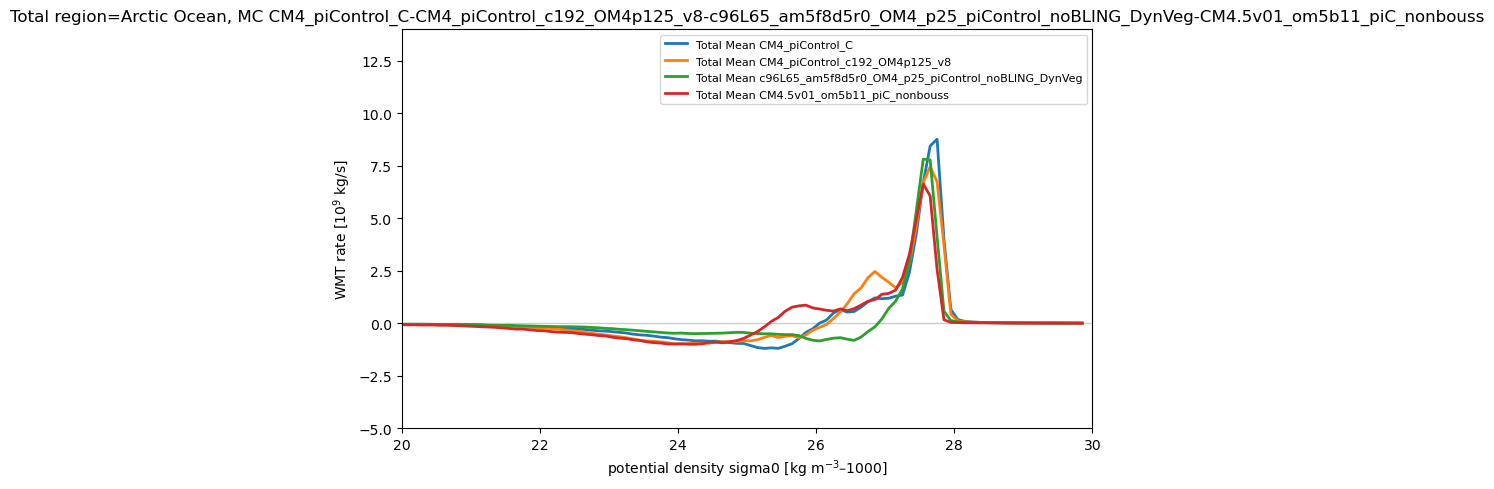

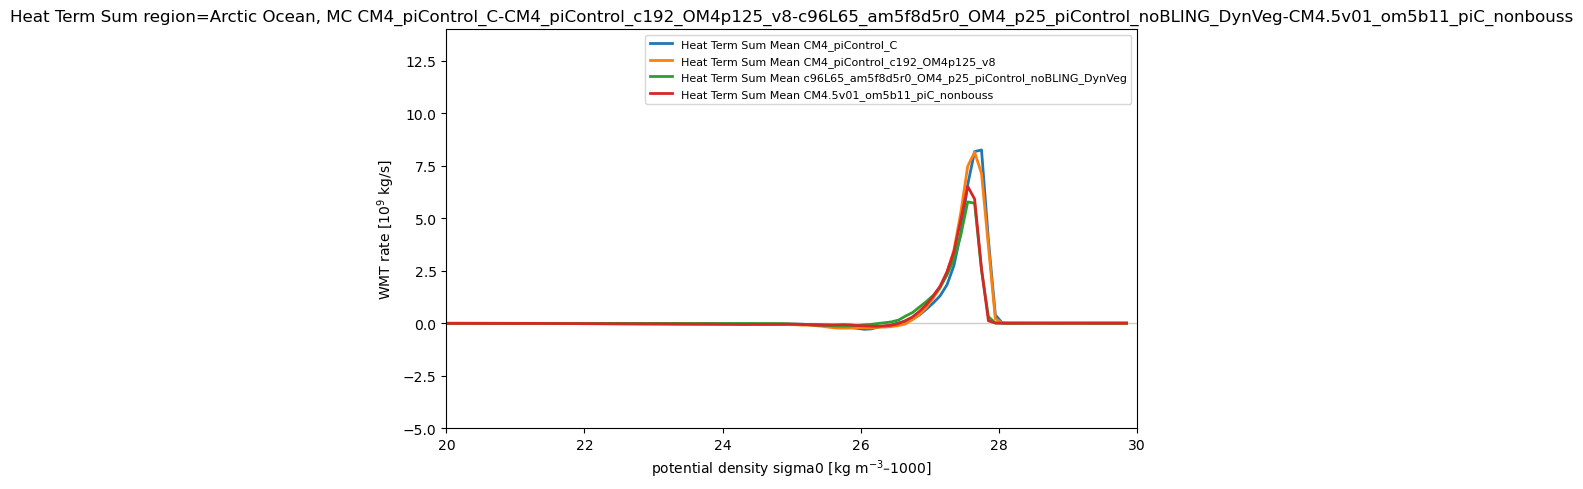

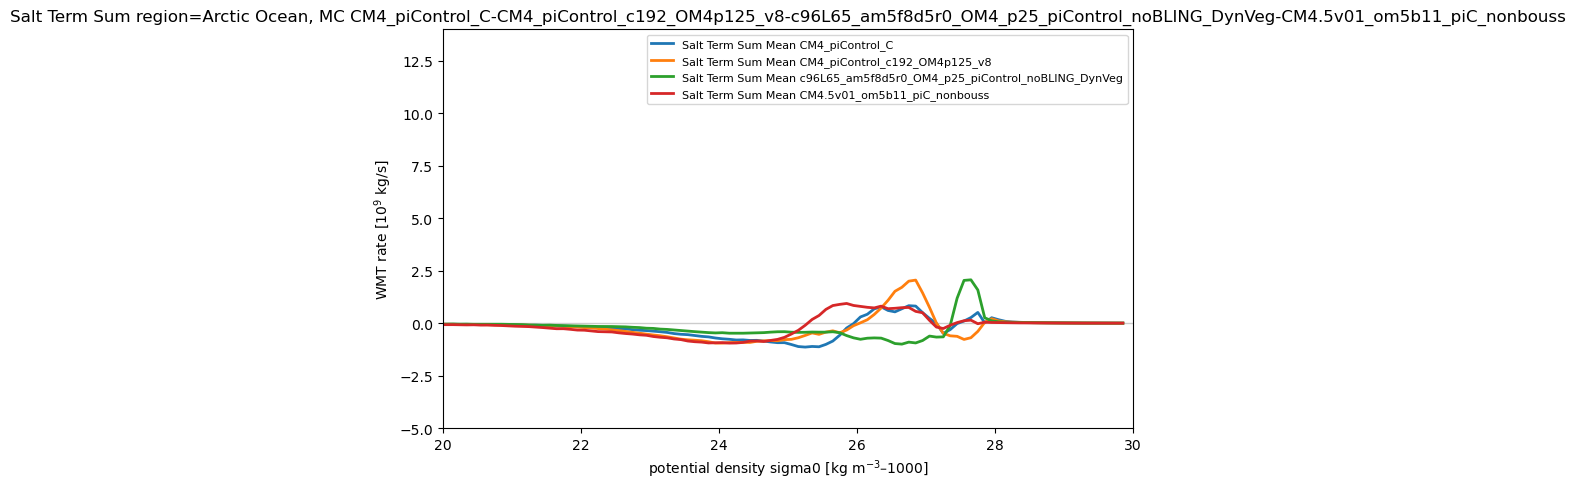

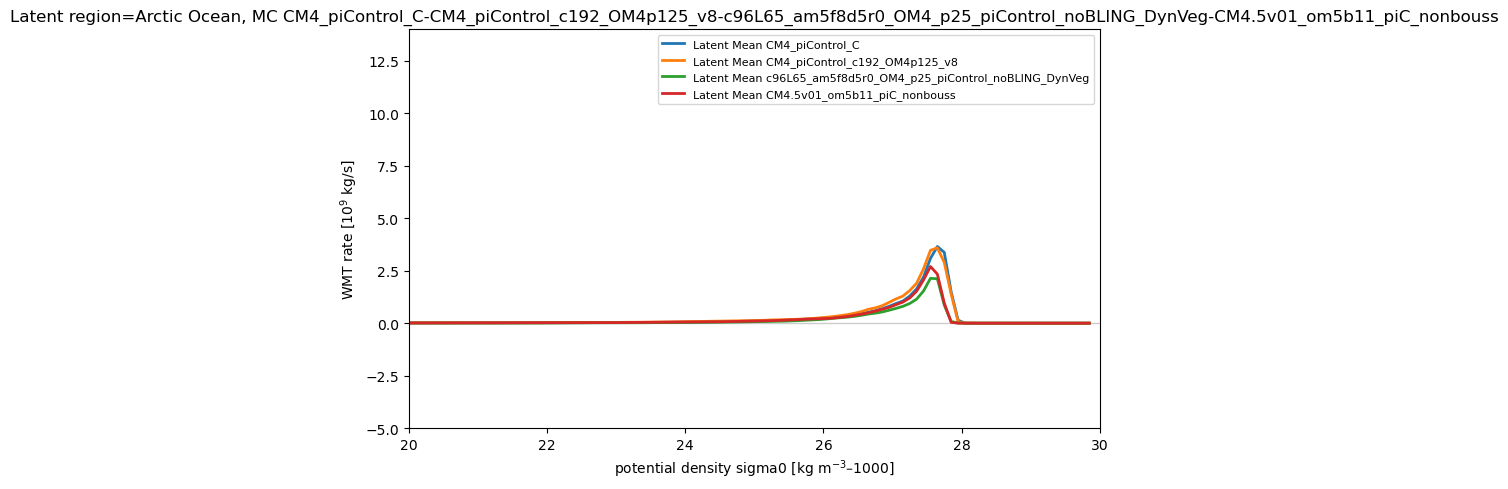

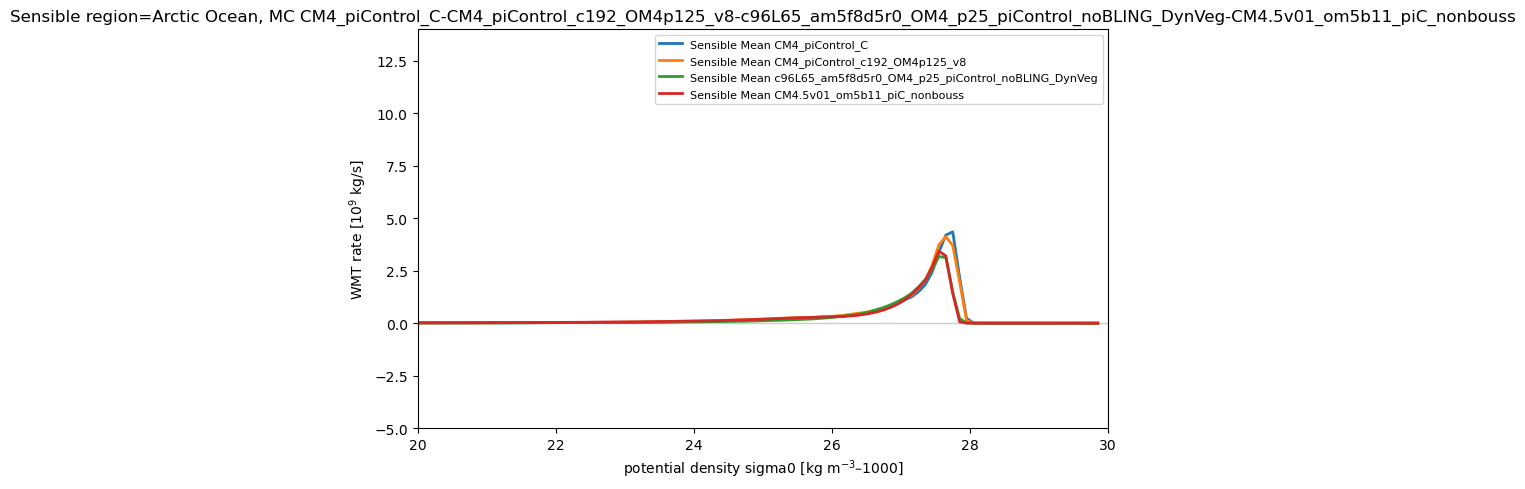

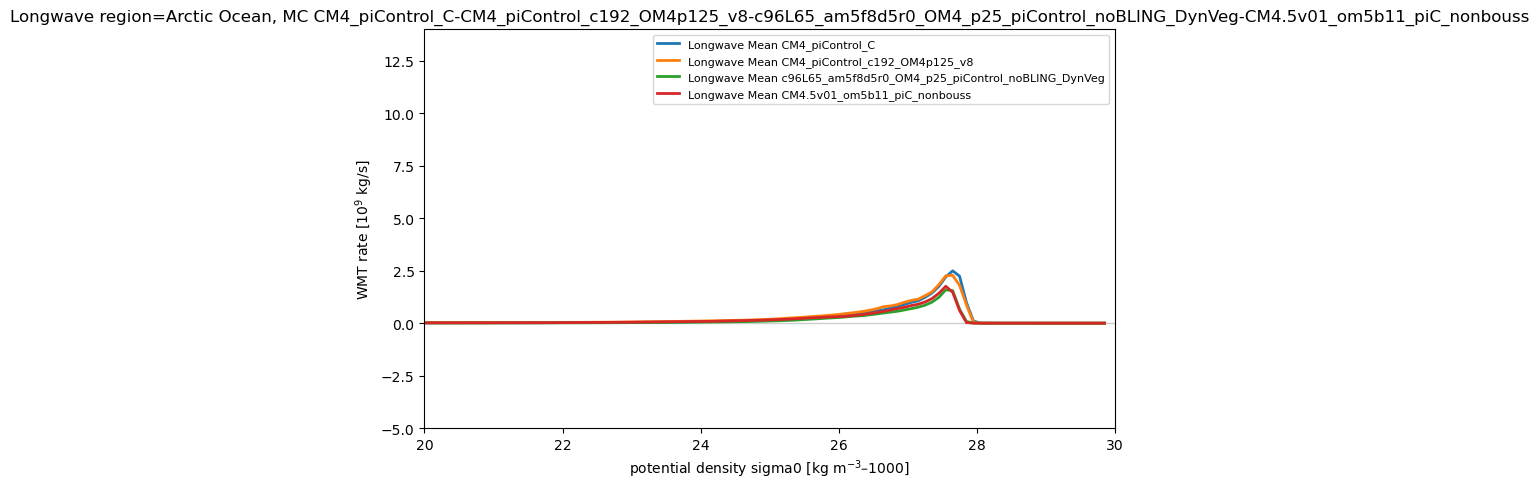

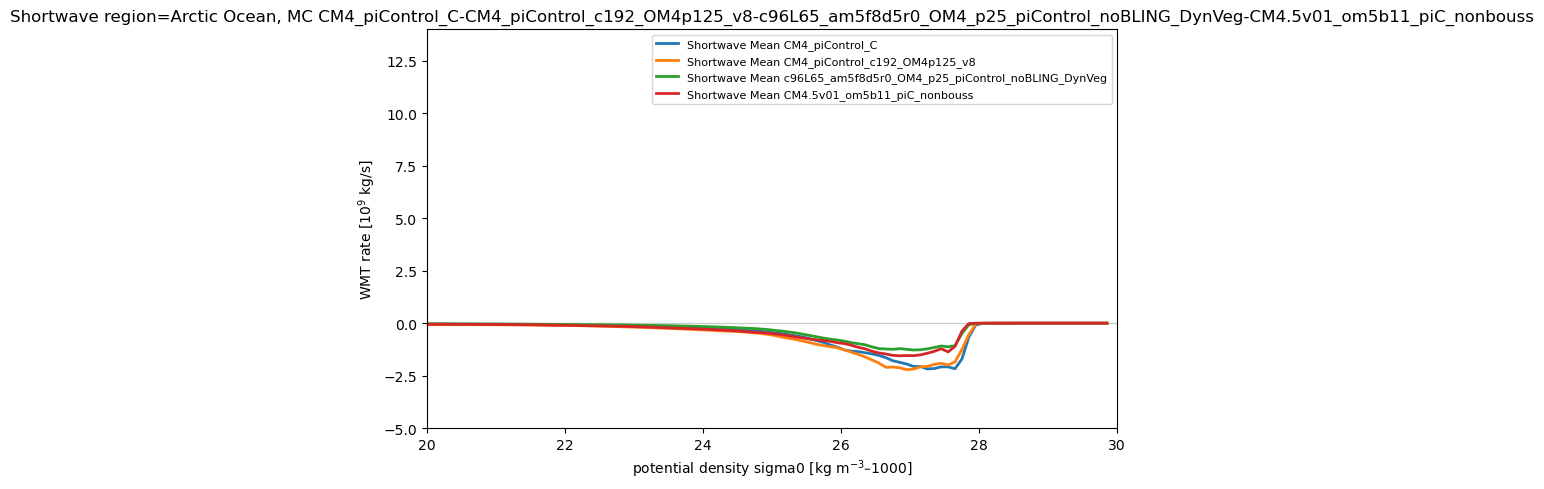

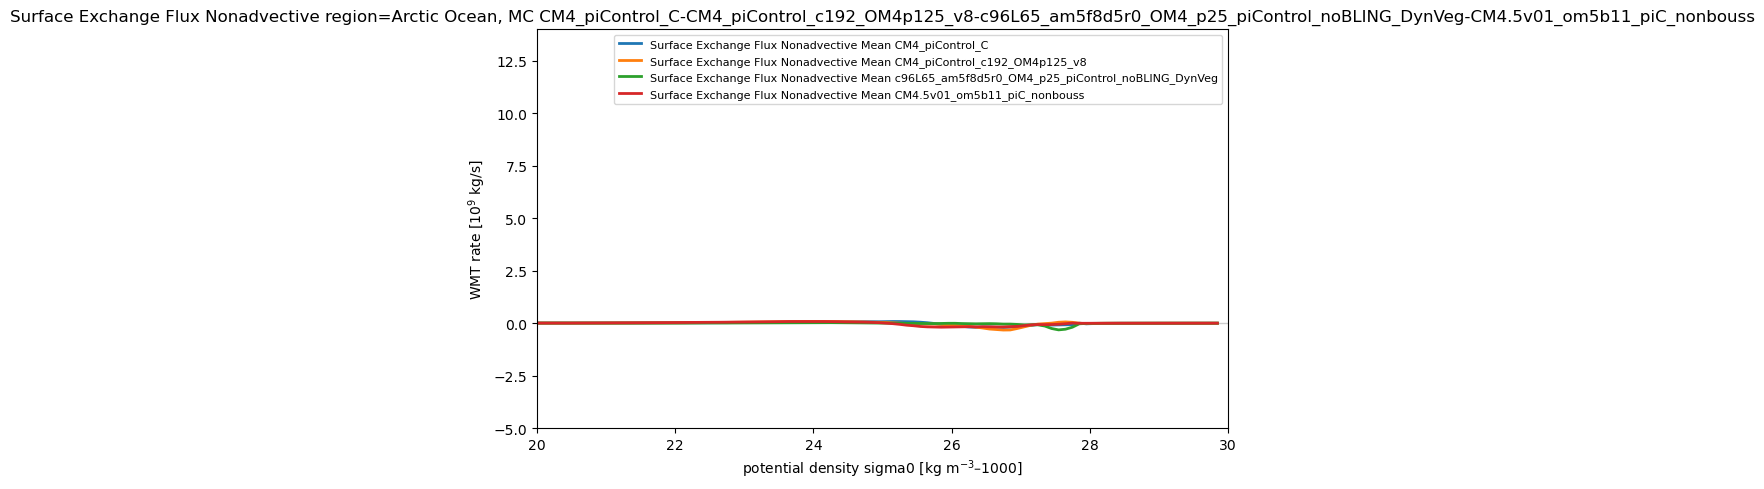

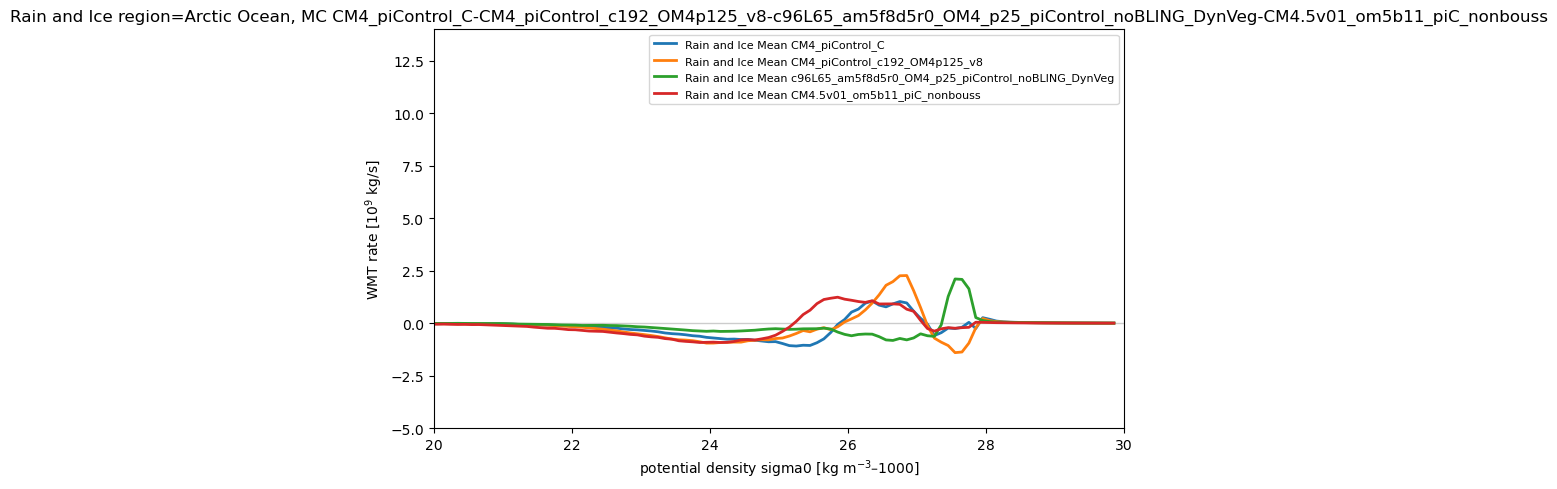

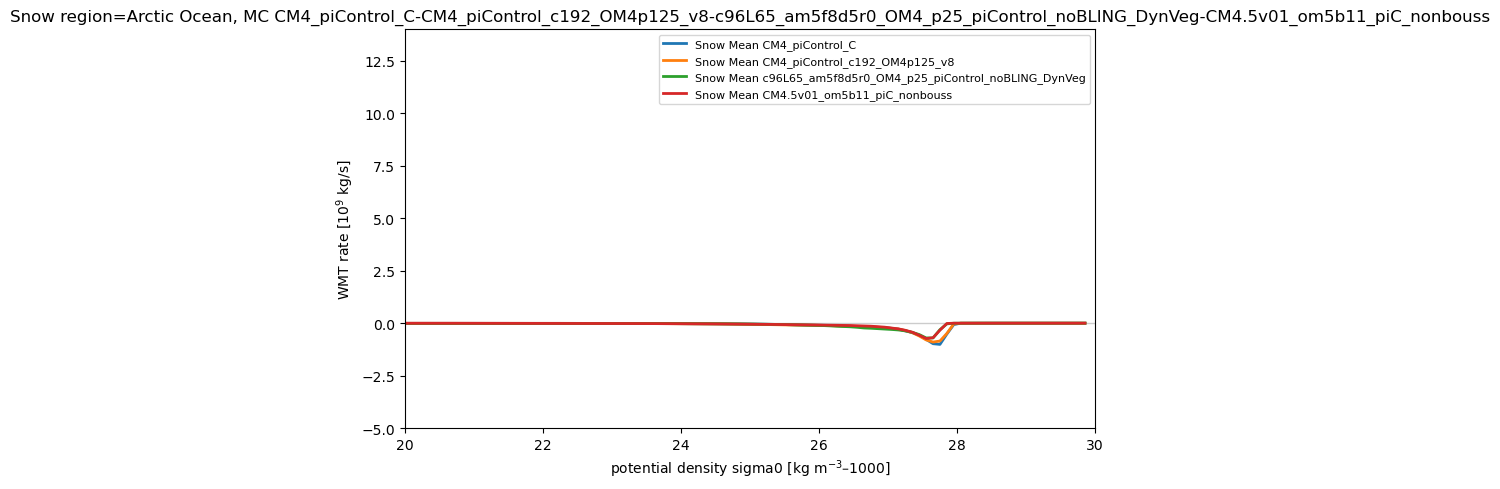

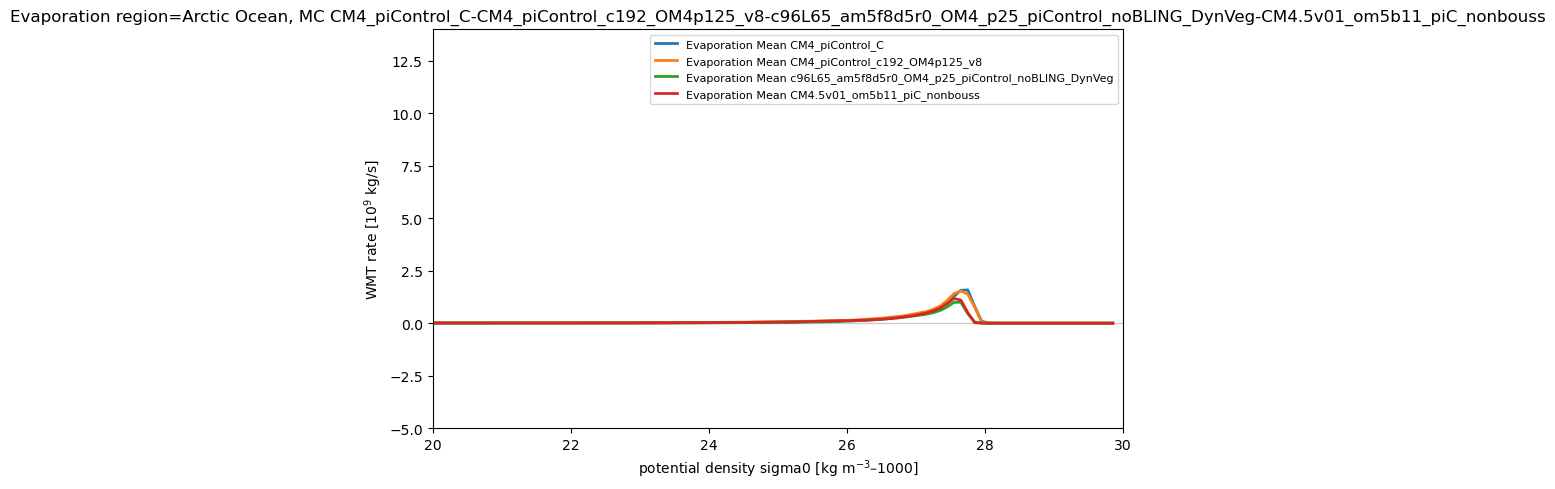

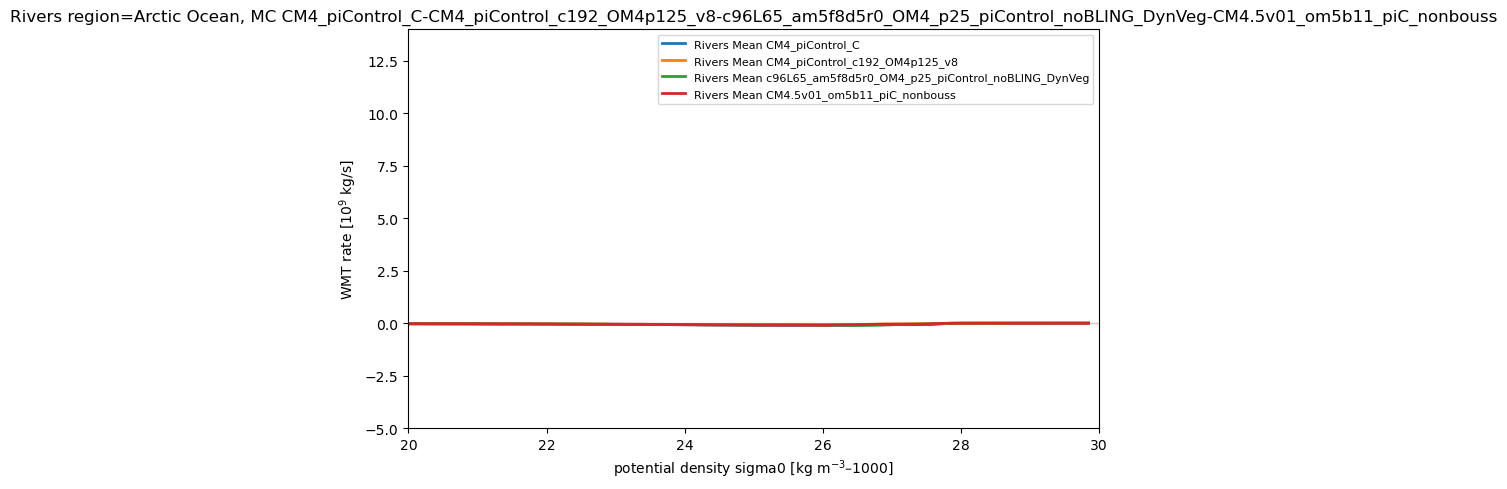

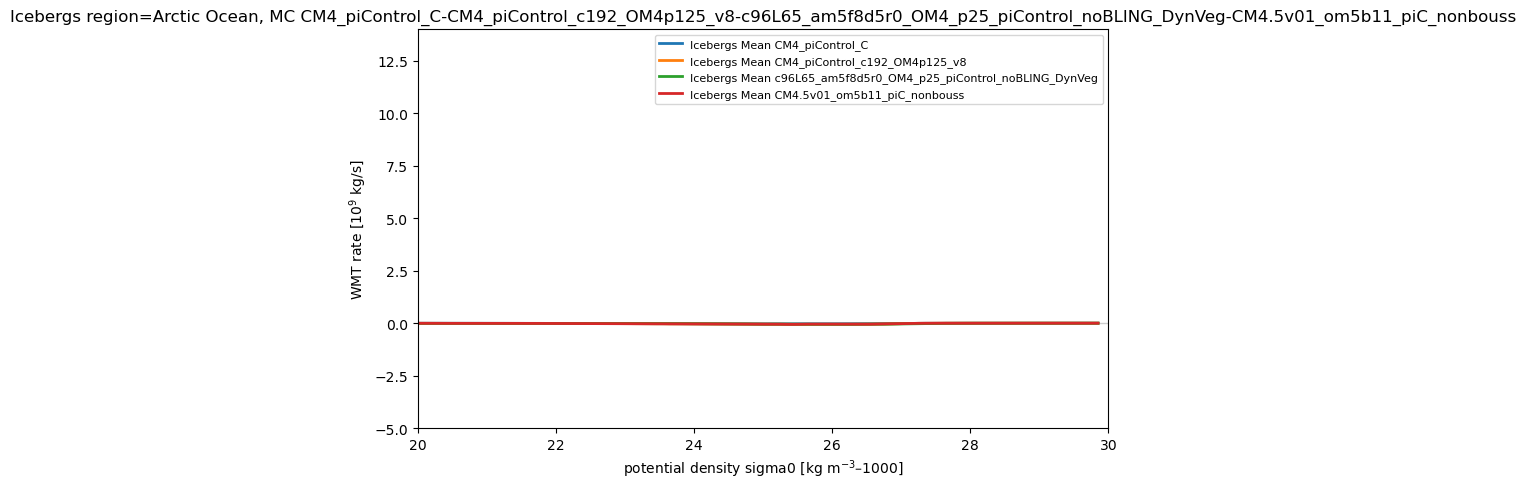

/nbhome/ogrp/python/envs/py312_20250611/lib/python3.12/site-packages/xgcm/transform.py:481: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/ogrp/python/envs/py312_20250611/lib/python3.12/site-packages/xgcm/transform.py:481: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/ogrp/python/envs/py312_20250611/lib/python3.12/site-packages/xgcm/transform.py:481: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/nbhome/ogrp/python/envs/py312_202506

In [ ]:
basin_code_list = [["Arctic Ocean",4]]
lstr='sigma0'
budgets_dict, cp, rho_ref = get_budgets_dict()
raw_dsets = realm_list()
year_chunk_length = 20
number_samples_generated = 1
ordered_chunk = True

ocean_only = [ row[0] for row in raw_dsets ]
ice_only = [ row[1] for row in raw_dsets ]
dsets_mc_list = create_mc_list(
    ocean_only,
    number_samples_generated=number_samples_generated,
    year_chunk_length=year_chunk_length,
    ordered_chunk=ordered_chunk
)

dsets_mc_ice = create_mc_list(
    ice_only,
    number_samples_generated=number_samples_generated,
    year_chunk_length=year_chunk_length,
    ordered_chunk=ordered_chunk
)

for region_i, basin_integer in basin_code_list:
    dsets_copy, basincodes_arr = groupCoordinateChange(dsets_mc_list, groups, basin_integer=basin_integer)
    dictionary_terms = swmt_average_transformation(dsets_copy, budgets_dict, cp, rho_ref, region=region_i, lstr=lstr)
    list_F_mean_list, mask_const, name_list, sigma_bin = projection_map(dictionary_terms)
    list_F_mean_rg = rename_regrid(list_F_mean_list)
    

In [ ]:
net_transformation_keys = ['total', 'salt_term_sum', 'heat_term_sum']

In [ ]:

n_runs = len(list_F_mean_rg)
flat_mc_ice = [ds for sublist in dsets_mc_ice for ds in sublist]
flat_name_list = [name for sublist in name_list for name in sublist]
sigma_bin_locs = dictionary_terms['max_amp_loc']
flat_sigma_bin_locs = [bin_i for sublist in sigma_bin_locs for bin_i in sublist]

for item in net_transformation_keys:
    # create 1 x n_runs subplots
    fig, axes = plt.subplots(
        1, n_runs,
        figsize=(6 * n_runs, 6),
        subplot_kw={'projection': ccrs.NorthPolarStereo()},
        constrained_layout=True
    )
    fig.suptitle(f"{region_i} {item} SWMT",
                 fontsize=18, y=1.05)

    last_mesh = None

    for idx, list_F_mean in enumerate(list_F_mean_rg):
        ax = axes[idx] if n_runs > 1 else axes

        ds = flat_mc_ice[idx].copy(deep=True).rename({"xT": "xh", "yT": "yh"})
        siconc_rg = rename_regrid([ds], resolution=.25)[0]
        deptho_1k = rename_regrid([ds], resolution=1)[0]
        monthly = siconc_rg.groupby("time.month").mean("time")
        march = monthly.sel(month=3)
        sept = monthly.sel(month=9)
        siext_march = march.where(march['siconc'] > .15)
        siext_sept  = sept.where(sept['siconc'] > .15)

        tot = list_F_mean[item]
        vmax = .0015
        vmin = -vmax
        
        cmap = plt.get_cmap('BrBG')
        cmap.set_bad('lightgrey')
        mesh = tot.plot(
            x='lon', y='lat', ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap, vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        last_mesh = mesh

        ax.contour(sept.lon, sept.lat, sept.siconc,
                   levels=[0.15], colors='magenta', linewidths=1.5,
                   transform=ccrs.PlateCarree(), zorder=3)
        ax.contour(march.lon, march.lat, march.siconc,
                   levels=[0.15], colors='black', linewidths=1.5,
                   transform=ccrs.PlateCarree(), zorder=3)
        ax.contour(deptho_1k.lon, deptho_1k.lat, deptho_1k.deptho,
                   levels=[1000.], colors='black', linewidths=0.5,
                   transform=ccrs.PlateCarree(), zorder=3)
        min_year0 = dsets_mc_list[idx][0].time.min().item().year
        max_year1 = dsets_mc_list[idx][0].time.max().item().year
        ax.set_title(f"{flat_name_list[idx]} ({min_year0}-{max_year1}) $\\sigma_0$={str(flat_sigma_bin_locs[idx])[:6]}", fontsize=14)
        ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

    mar_handle = Line2D([], [], color='black', lw=2, label='March ice edge')
    sept_handle= Line2D([], [], color='magenta',   lw=2, label='Sept ice edge')
    if n_runs > 1:
        axes[0].legend(handles=[mar_handle, sept_handle],
                       loc='upper left', frameon=True)
    else:
        ax.legend(handles=[mar_handle, sept_handle],
                       loc='upper left', frameon=True)
        
    cbar = fig.colorbar(
        last_mesh, ax=axes,
        orientation='vertical', fraction=0.05, pad=0.02, aspect=20
    )
    cbar.set_label('SWMT [10⁹ kg/s]', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #plt.savefig(f"/work/Theo.Avila/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/presentation/" + 
    #            f"swmt_2d_{region_i}_{lstr}_{str(sigma_bin)[:6]}_chunk{year_chunk_length}_numsamples{number_samples_generated}_{idx}_{item}_{flat_name_list}_40_100_yr.png")
        